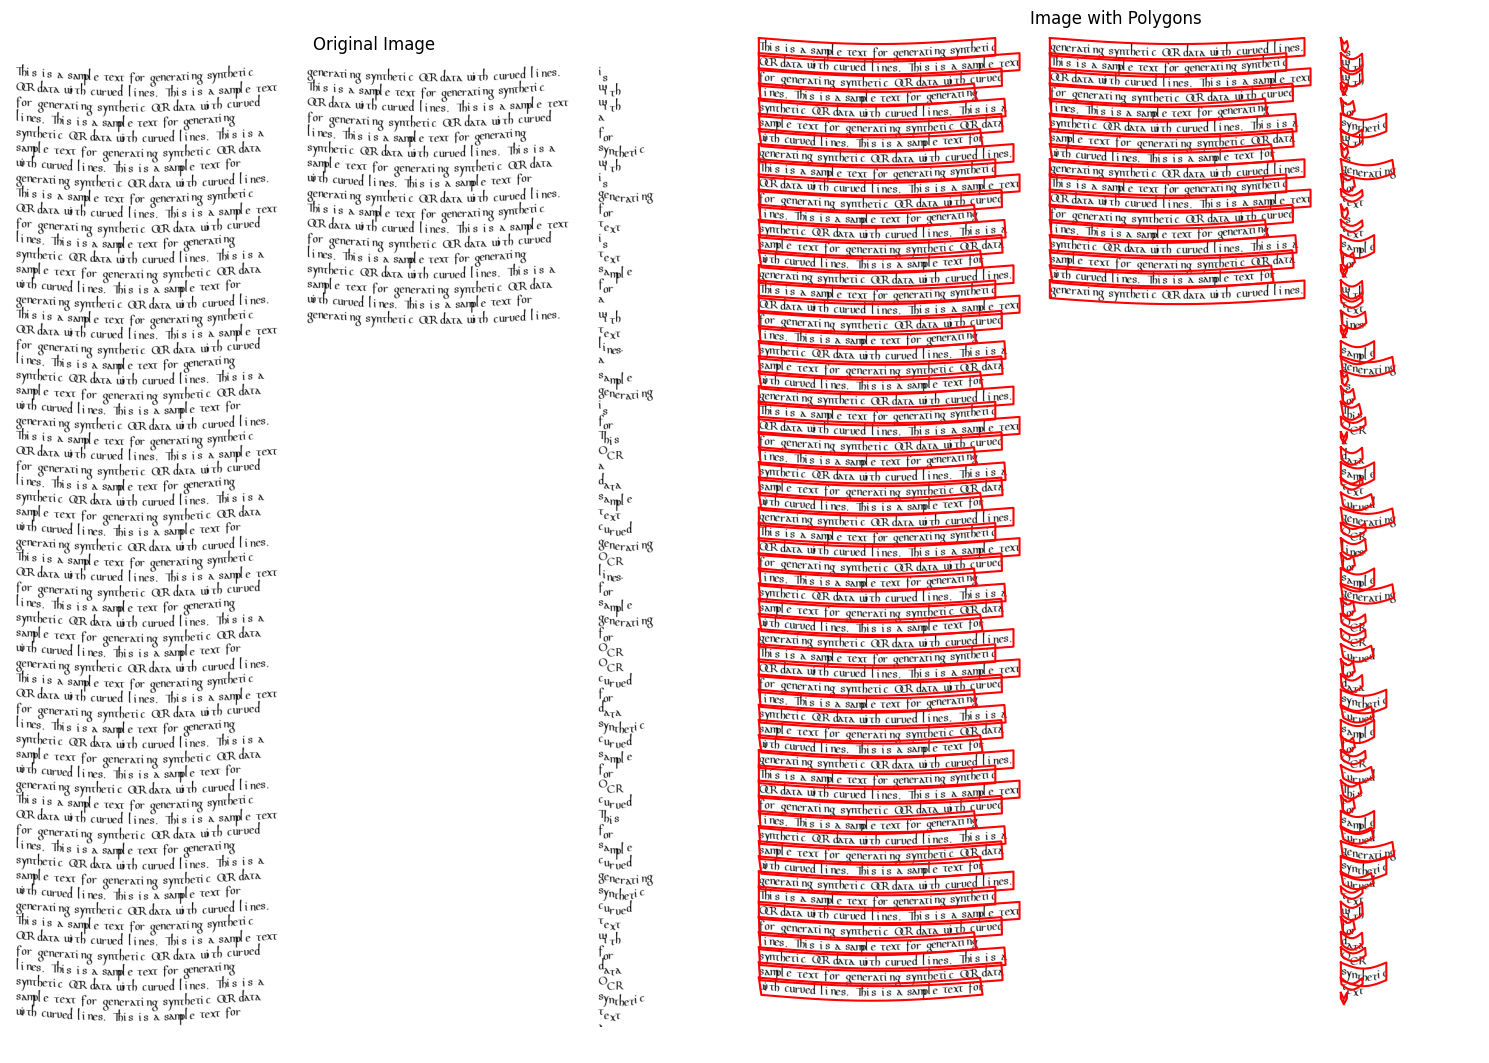

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from typing import List, Tuple

def save_alto_xml(alto: ET.Element, filename: str):
    rough_string = ET.tostring(alto, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    with open(filename, "w", encoding="utf-8") as f:
        f.write(reparsed.toprettyxml(indent="  "))

def generate_synthetic_ocr_data(
    text: str,
    width: int = 1200,
    height: int = 1600,
    font_size: int = 20,
    num_columns: int = 1,
    marginalia: bool = False,
    marginalia_probability: float = 0.2,
    curve_amount: float = 0.0
) -> Tuple[Image.Image, List[Tuple[str, List[Tuple[int, int]]]]]:
    # Create a blank white image
    image = Image.new('RGB', (width, height), color='white')
    draw = ImageDraw.Draw(image)
    
    # Load a font
    font = ImageFont.truetype("medieval.otf", font_size)
    
    # Calculate column widths
    main_width = int(width * 0.8)  # Main text takes 80% of the width
    margin_width = width - main_width  # Marginalia takes the remaining 20%
    column_width = main_width // num_columns
    
    # Split text into words
    words = text.split()
    
    # Initialize variables
    x, y = 10, 10
    line_height = font_size + 5
    current_column = 0
    text_polygons = []
    current_line = []
    line_start_y = y
    
    def add_curved_line_polygon(line_text, start_x, start_y):
        bbox = draw.textbbox((start_x, start_y), line_text, font=font)
        line_width = bbox[2] - bbox[0]
        line_height = bbox[3] - bbox[1]
        
        # Calculate curve
        curve = np.sin(np.linspace(0, np.pi, line_width)) * curve_amount * font_size
        
        # Draw curved text
        for i, char in enumerate(line_text):
            char_x = start_x + i * (line_width / len(line_text))
            char_y = start_y + curve[int(i * (line_width / len(line_text)))]
            draw.text((char_x, char_y), char, fill='black', font=font)
        
        # Create polygon points
        polygon_points = []
        for i in range(0, line_width, 5):
            polygon_points.append((start_x + i, start_y + curve[i]))
        for i in range(line_width-1, -1, -5):
            polygon_points.append((start_x + i, start_y + curve[i] + line_height))
        
        text_polygons.append((line_text, polygon_points))
    
    for word in words:
        bbox = draw.textbbox((x, y), word, font=font)
        word_width = bbox[2] - bbox[0]
        
        if x + word_width > (current_column + 1) * column_width - 10:
            # Draw the current line
            line_text = " ".join(current_line)
            add_curved_line_polygon(line_text, (column_width * current_column) + 10, line_start_y)
            current_line.clear()
            
            # Move to the next line
            x = (column_width * current_column) + 10
            y += line_height
            line_start_y = y
            
            if y + line_height > height - 10:
                current_column += 1
                if current_column >= num_columns:
                    break
                x = (column_width * current_column) + 10
                y = 10
                line_start_y = y
        
        current_line.append(word)
        x += word_width + font_size // 2
    
    # Draw any remaining words in the last line
    if current_line:
        line_text = " ".join(current_line)
        add_curved_line_polygon(line_text, (column_width * current_column) + 10, line_start_y)
    
    # Add marginalia if requested
    if marginalia:
        margin_x = main_width + 10
        margin_y = 10
        margin_lines = []
        
        for _ in range(int(len(words) * marginalia_probability)):
            margin_text = np.random.choice(words)
            margin_lines.append(margin_text)
            
            if len(margin_lines) * line_height > height - 20:
                break
        
        for margin_text in margin_lines:
            add_curved_line_polygon(margin_text, margin_x, margin_y)
            margin_y += line_height
    
    return image, text_polygons

def visualize_results(image: Image.Image, polygons: List[Tuple[str, List[Tuple[int, int]]]]):
    # Display original image
    plt.figure(figsize=(15, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    # Display image with polygons
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    for _, poly in polygons:
        x, y = zip(*poly)
        plt.plot(x + x[:1], y + y[:1], 'r-')
    plt.title("Image with Polygons")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
text = "This is a sample text for generating synthetic OCR data with curved lines. " * 50
image, polygons = generate_synthetic_ocr_data(text, num_columns=2, marginalia=True, curve_amount=0.5)
visualize_results(image, polygons)

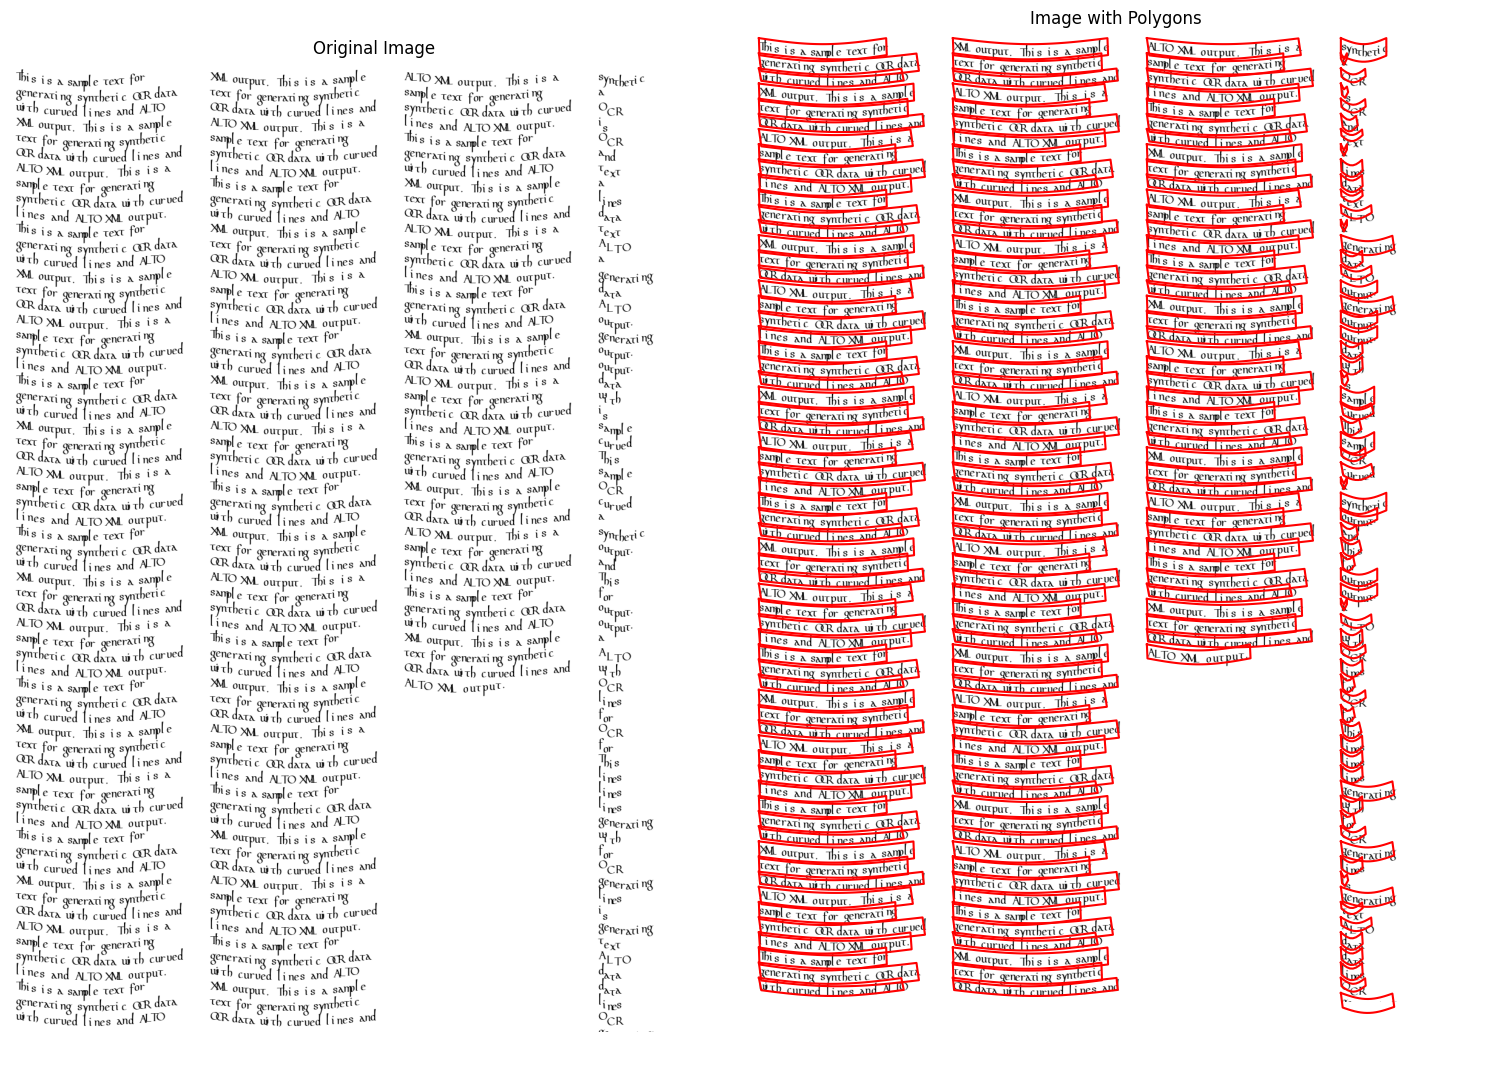

Image and ALTO XML files have been saved.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from typing import List, Tuple
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def generate_synthetic_ocr_data(
    text: str,
    width: int = 1200,
    height: int = 1600,
    font_size: int = 20,
    num_columns: int = 1,
    marginalia: bool = False,
    marginalia_probability: float = 0.2,
    curve_amount: float = 0.0
) -> Tuple[Image.Image, List[Tuple[str, List[Tuple[int, int]]]], ET.Element]:
    # Create a blank white image
    image = Image.new('RGB', (width, height), color='white')
    draw = ImageDraw.Draw(image)
    
    # Load a font
    font = ImageFont.truetype("medieval.otf", font_size)
    
    # Calculate column widths
    main_width = int(width * 0.8)  # Main text takes 80% of the width
    margin_width = width - main_width  # Marginalia takes the remaining 20%
    column_width = main_width // num_columns
    
    # Split text into words
    words = text.split()
    
    # Initialize variables
    x, y = 10, 10
    line_height = font_size + 5
    current_column = 0
    text_polygons = []
    current_line = []
    line_start_y = y
    
    # Initialize ALTO XML structure
    alto = ET.Element("alto", xmlns="http://www.loc.gov/standards/alto/ns-v4#")
    layout = ET.SubElement(alto, "Layout")
    page = ET.SubElement(layout, "Page", ID="PAGE_0001", PHYSICAL_IMG_NR="1", HEIGHT=str(height), WIDTH=str(width))
    print_space = ET.SubElement(page, "PrintSpace", ID="PS_0001")
    current_text_block = ET.SubElement(print_space, "TextBlock", ID="TB_0001")
    
    def add_curved_line_polygon(line_text, start_x, start_y, block_id):
        bbox = draw.textbbox((start_x, start_y), line_text, font=font)
        line_width = bbox[2] - bbox[0]
        line_height = bbox[3] - bbox[1]
        
        # Calculate curve
        curve = np.sin(np.linspace(0, np.pi, line_width)) * curve_amount * font_size
        
        # Draw curved text
        for i, char in enumerate(line_text):
            char_x = start_x + i * (line_width / len(line_text))
            char_y = start_y + curve[int(i * (line_width / len(line_text)))]
            draw.text((char_x, char_y), char, fill='black', font=font)
        
        # Create polygon points
        polygon_points = []
        for i in range(0, line_width, 5):
            polygon_points.append((start_x + i, start_y + curve[i]))
        for i in range(line_width-1, -1, -5):
            polygon_points.append((start_x + i, start_y + curve[i] + line_height))
        
        text_polygons.append((line_text, polygon_points))
        
        # Add line to ALTO XML
        text_line = ET.SubElement(current_text_block, "TextLine", ID=f"TL_{block_id}")
        coords = " ".join([f"{int(x)},{int(y)}" for x, y in polygon_points])
        ET.SubElement(text_line, "Coords", POINTS=coords)
        string = ET.SubElement(text_line, "String", CONTENT=line_text)
    
    block_counter = 1
    for word in words:
        bbox = draw.textbbox((x, y), word, font=font)
        word_width = bbox[2] - bbox[0]
        
        if x + word_width > (current_column + 1) * column_width - 10:
            # Draw the current line
            line_text = " ".join(current_line)
            add_curved_line_polygon(line_text, (column_width * current_column) + 10, line_start_y, block_counter)
            block_counter += 1
            current_line.clear()
            
            # Move to the next line
            x = (column_width * current_column) + 10
            y += line_height
            line_start_y = y
            
            if y + line_height > height - 10:
                current_column += 1
                if current_column >= num_columns:
                    break
                x = (column_width * current_column) + 10
                y = 10
                line_start_y = y
                current_text_block = ET.SubElement(print_space, "TextBlock", ID=f"TB_{current_column+1:04d}")
        
        current_line.append(word)
        x += word_width + font_size // 2
    
    # Draw any remaining words in the last line
    if current_line:
        line_text = " ".join(current_line)
        add_curved_line_polygon(line_text, (column_width * current_column) + 10, line_start_y, block_counter)
    
    # Add marginalia if requested
    if marginalia:
        margin_x = main_width + 10
        margin_y = 10
        margin_lines = []
        marginalia_block = ET.SubElement(print_space, "TextBlock", ID="TB_MARG")
        
        for _ in range(int(len(words) * marginalia_probability)):
            margin_text = np.random.choice(words)
            margin_lines.append(margin_text)
            
            if len(margin_lines) * line_height > height - 20:
                break
        
        for i, margin_text in enumerate(margin_lines):
            add_curved_line_polygon(margin_text, margin_x, margin_y, f"MARG_{i+1}")
            margin_y += line_height
    
    return image, text_polygons, alto

def visualize_results(image: Image.Image, polygons: List[Tuple[str, List[Tuple[int, int]]]]):
    # Display original image
    plt.figure(figsize=(15, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    # Display image with polygons
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    for _, poly in polygons:
        x, y = zip(*poly)
        plt.plot(x + x[:1], y + y[:1], 'r-')
    plt.title("Image with Polygons")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def save_alto_xml(alto: ET.Element, filename: str):
    rough_string = ET.tostring(alto, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    with open(filename, "w", encoding="utf-8") as f:
        f.write(reparsed.toprettyxml(indent="  "))

# Example usage
text = "This is a sample text for generating synthetic OCR data with curved lines and ALTO XML output. " * 50
image, polygons, alto = generate_synthetic_ocr_data(text, num_columns=3, marginalia=True, curve_amount=0.5)
visualize_results(image, polygons)

# Save the image and ALTO XML
image.save("synthetic_ocr_image.png")
save_alto_xml(alto, "synthetic_ocr_data.alto.xml")
print("Image and ALTO XML files have been saved.")

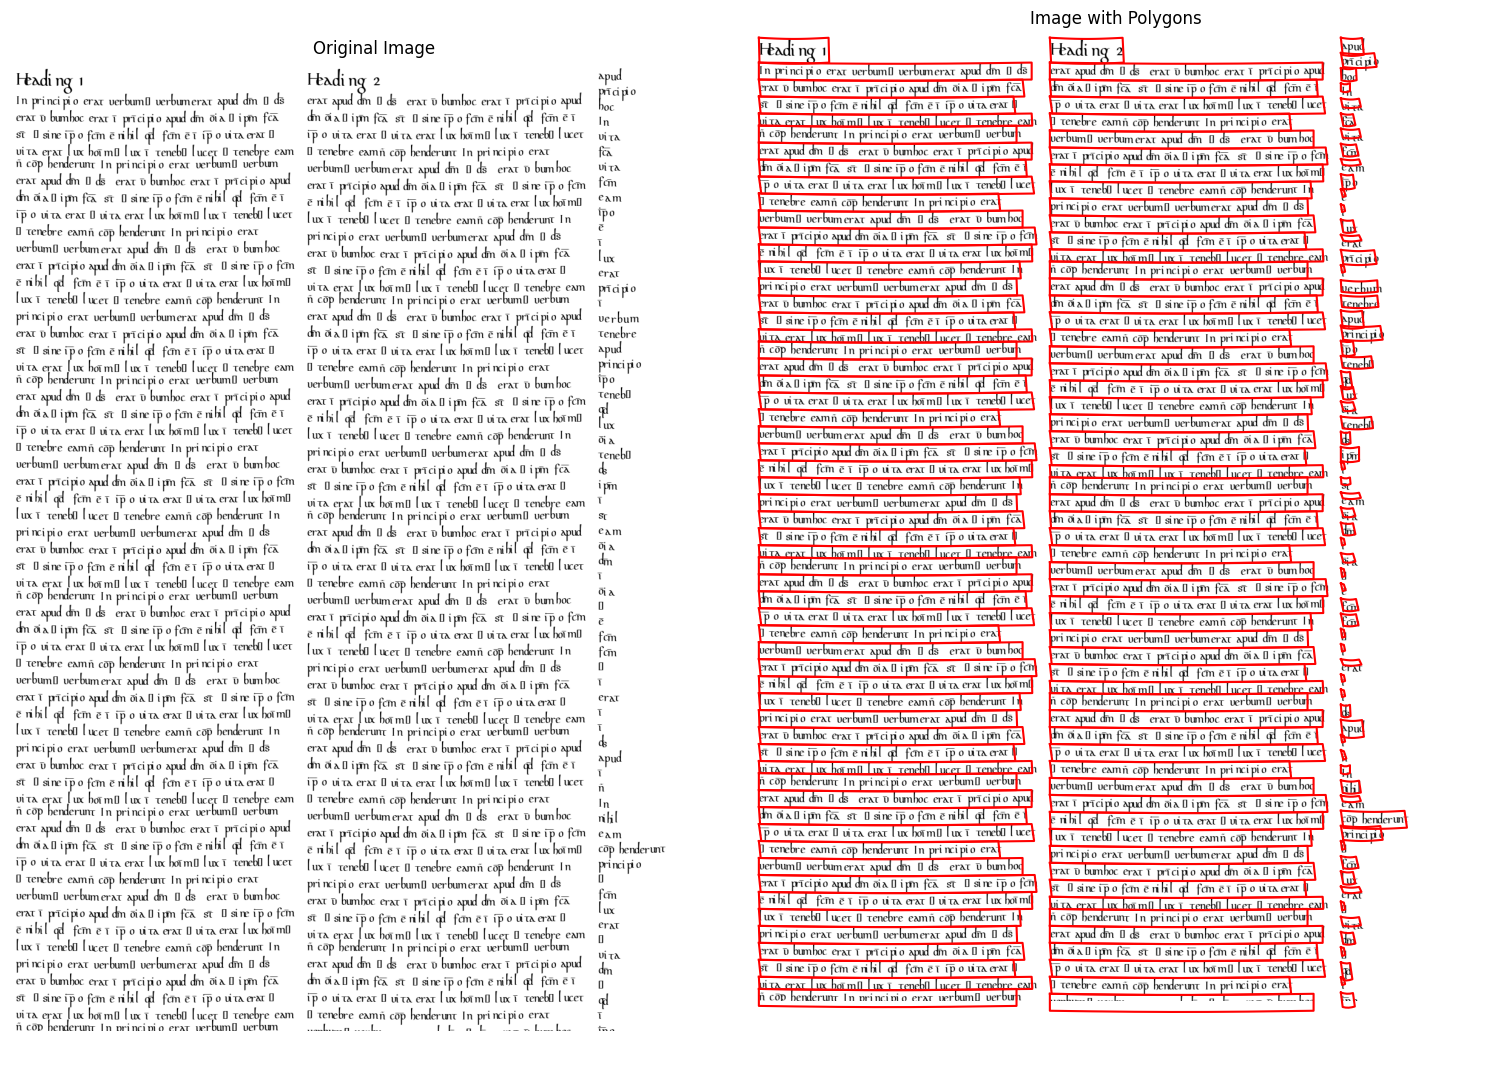

Image and ALTO XML files have been saved.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from typing import List, Tuple
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def generate_synthetic_ocr_data(
    text: str,
    width: int = 1200,
    height: int = 1600,
    font_size: int = 20,
    num_columns: int = 1,
    marginalia: bool = False,
    marginalia_probability: float = 0.2,
    curve_amount: float = 0.0,
    heading_lines: int = 0
) -> Tuple[Image.Image, List[Tuple[str, List[Tuple[int, int]]]], ET.Element]:
    # Create a blank white image
    image = Image.new('RGB', (width, height), color='white')
    draw = ImageDraw.Draw(image)
    
    # Load fonts
    font = ImageFont.truetype("medieval.otf", font_size)
    heading_font = ImageFont.truetype("medieval.otf", int(font_size * 1.5))
    
    # Calculate column widths
    main_width = int(width * 0.8)  # Main text takes 80% of the width
    margin_width = width - main_width  # Marginalia takes the remaining 20%
    column_width = main_width // num_columns
    
    # Split text into words and generate headings
    words = text.split()
    headings = [f"Heading {i+1}" for i in range(heading_lines)]
    
    # Initialize variables
    x, y = 10, 10
    line_height = font_size + 5
    heading_height = int(font_size * 1.5) + 10
    current_column = 0
    text_polygons = []
    current_line = []
    line_start_y = y
    
    # Initialize ALTO XML structure
    alto = ET.Element("alto", xmlns="http://www.loc.gov/standards/alto/ns-v4#")
    layout = ET.SubElement(alto, "Layout")
    page = ET.SubElement(layout, "Page", ID="PAGE_0001", PHYSICAL_IMG_NR="1", HEIGHT=str(height), WIDTH=str(width))
    print_space = ET.SubElement(page, "PrintSpace", ID="PS_0001")
    current_text_block = ET.SubElement(print_space, "TextBlock", ID="TB_0001")
    
    def add_curved_line_polygon(line_text, start_x, start_y, block_id, is_heading=False):
        font_to_use = heading_font if is_heading else font
        bbox = draw.textbbox((start_x, start_y), line_text, font=font_to_use)
        line_width = bbox[2] - bbox[0]
        line_height = bbox[3] - bbox[1]
        
        # Calculate curve
        curve = np.sin(np.linspace(0, np.pi, line_width)) * curve_amount * font_size
        
        # Draw curved text
        for i, char in enumerate(line_text):
            char_x = start_x + i * (line_width / len(line_text))
            char_y = start_y + curve[int(i * (line_width / len(line_text)))]
            draw.text((char_x, char_y), char, fill='black', font=font_to_use)
        
        # Create polygon points
        polygon_points = []
        for i in range(0, line_width, 5):
            polygon_points.append((start_x + i, start_y + curve[i]))
        for i in range(line_width-1, -1, -5):
            polygon_points.append((start_x + i, start_y + curve[i] + line_height))
        
        text_polygons.append((line_text, polygon_points))
        
        # Add line to ALTO XML
        text_line = ET.SubElement(current_text_block, "TextLine", ID=f"TL_{block_id}")
        coords = " ".join([f"{int(x)},{int(y)}" for x, y in polygon_points])
        ET.SubElement(text_line, "Coords", POINTS=coords)
        string = ET.SubElement(text_line, "String", CONTENT=line_text)
        if is_heading:
            string.set("STYLE", "heading")
        
        return line_height if is_heading else line_height
    
    block_counter = 1
    heading_index = 0
    
    while words or heading_index < len(headings):
        # Start a new text block for each column
        current_text_block = ET.SubElement(print_space, "TextBlock", ID=f"TB_{current_column+1:04d}")
        x = (column_width * current_column) + 10
        y = 10
        
        # Add a heading if available
        if heading_index < len(headings):
            y += add_curved_line_polygon(headings[heading_index], x, y, f"H_{block_counter}", is_heading=True)
            heading_index += 1
            block_counter += 1
        
        while y < height - 10 and words:
            current_line = []
            line_start_x = x
            
            while words and x + draw.textbbox((0, 0), words[0], font=font)[2] <= (current_column + 1) * column_width - 10:
                word = words.pop(0)
                current_line.append(word)
                x += draw.textbbox((0, 0), word + " ", font=font)[2]
            
            if current_line:
                line_text = " ".join(current_line)
                y += add_curved_line_polygon(line_text, line_start_x, y, block_counter)
                block_counter += 1
            
            x = (column_width * current_column) + 10
        
        current_column += 1
        if current_column >= num_columns:
            break
    
    # Add marginalia if requested
    if marginalia:
        margin_x = main_width + 10
        margin_y = 10
        margin_lines = []
        marginalia_block = ET.SubElement(print_space, "TextBlock", ID="TB_MARG")
        
        for _ in range(int(len(text.split()) * marginalia_probability)):
            margin_text = np.random.choice(text.split())
            margin_lines.append(margin_text)
            
            if len(margin_lines) * line_height > height - 20:
                break
        
        for i, margin_text in enumerate(margin_lines):
            add_curved_line_polygon(margin_text, margin_x, margin_y, f"MARG_{i+1}")
            margin_y += line_height
    
    return image, text_polygons, alto

def visualize_results(image: Image.Image, polygons: List[Tuple[str, List[Tuple[int, int]]]]):
    # Display original image
    plt.figure(figsize=(15, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    # Display image with polygons
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    for _, poly in polygons:
        x, y = zip(*poly)
        plt.plot(x + x[:1], y + y[:1], 'r-')
    plt.title("Image with Polygons")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def save_alto_xml(alto: ET.Element, filename: str):
    rough_string = ET.tostring(alto, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    with open(filename, "w", encoding="utf-8") as f:
        f.write(reparsed.toprettyxml(indent="  "))

# Example usage
text = "In principio erat verbum ⁊ verbum erat apud dm̄ ⁊ ds̄ erat v̄bum hoc erat ī prīcipio apud dm̄ ōia ꝑ ipm̄ fca̅ st̄ ⁊ sine ip̅o fcm̄ ē nihil qd̄ fcm̄ ē ī ip̅o vita erat ⁊ vita erat lux hoīm ⁊ lux ī tenebꝭ lucet ⁊ tenebre eam ñ cōp̄henderunt" * 50
image, polygons, alto = generate_synthetic_ocr_data(text, num_columns=2, marginalia=True, curve_amount=0.1, heading_lines=3)
visualize_results(image, polygons)

# Save the image and ALTO XML
image.save("synthetic_ocr_image.png")
save_alto_xml(alto, "synthetic_ocr_data.alto.xml")
print("Image and ALTO XML files have been saved.")

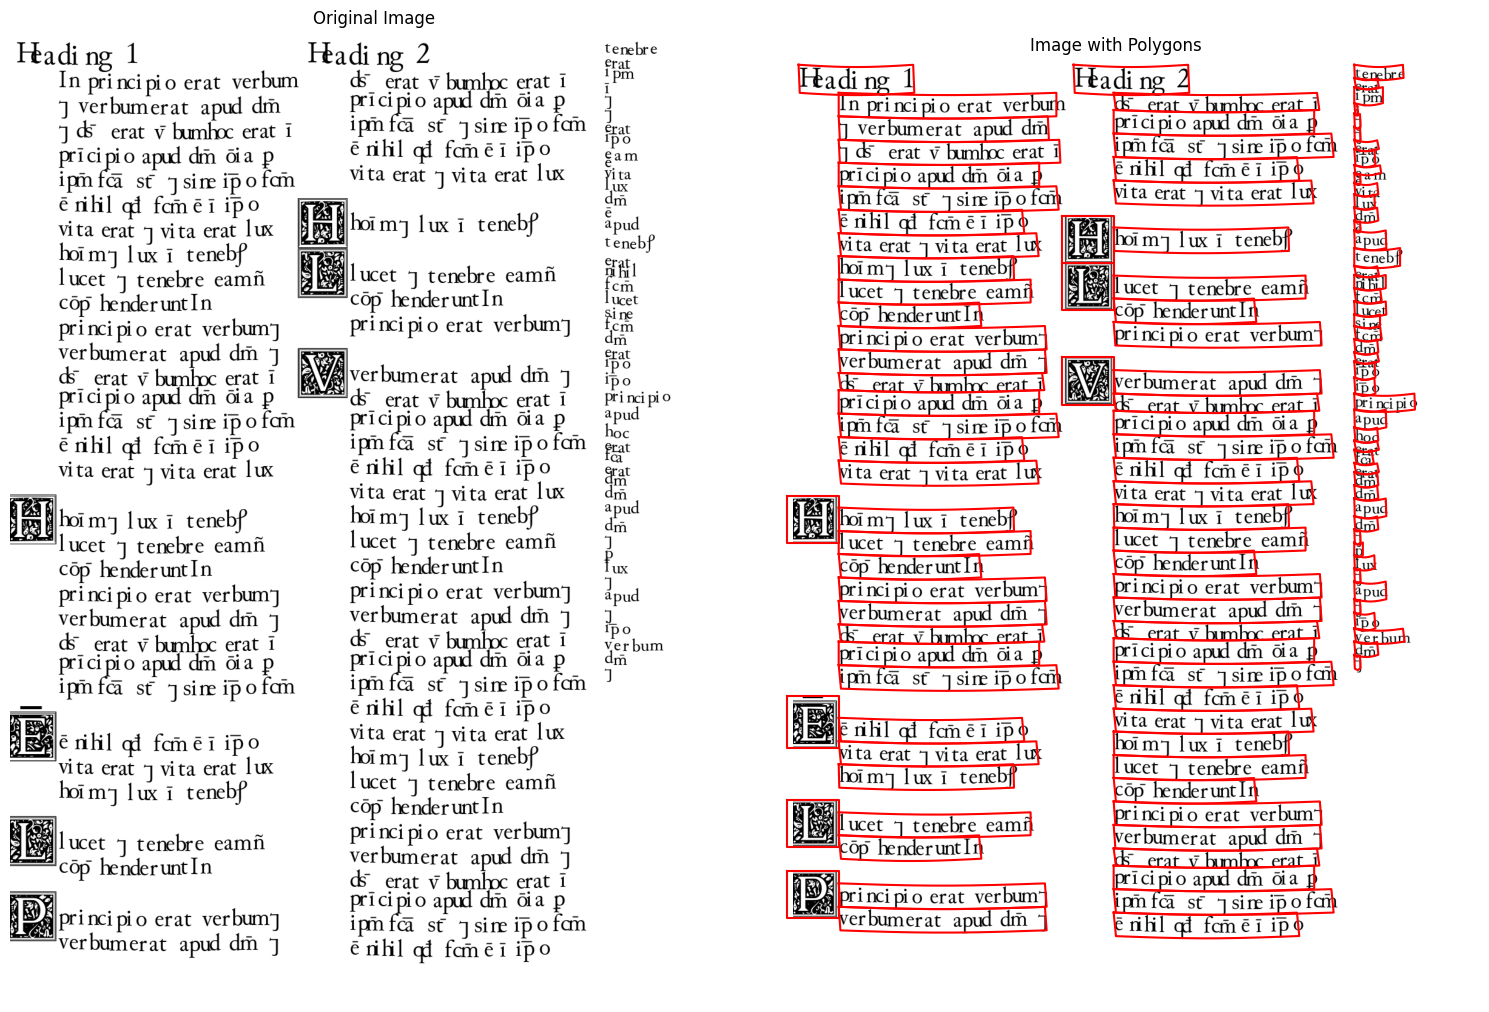

Image and ALTO XML files have been saved.


In [44]:
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from typing import List, Tuple
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def generate_synthetic_ocr_data(
    text: str,
    width: int = 1200,
    height: int = 1600,
    font_size: int = 20,
    num_columns: int = 1,
    marginalia: bool = False,
    marginalia_probability: float = 0.2,
    curve_amount: float = 0.0,
    heading_lines: int = 0,
    drop_cap_probability: float = 0.1,
    drop_cap_font_size: int = 40,
    drop_cap_position: int = 5,
    drop_cap_offset: int = 0,
    marginalia_font_size: int = 14,
    heading_font_size: int = 30,
    main_font_file: str = "medieval.otf",
    heading_font_file: str = "medieval.otf",
    marginalia_font_file: str = "medieval.otf",
    drop_cap_font_file: str = "HeavyRain-X3y9P.ttf",
) -> Tuple[Image.Image, List[Tuple[str, List[Tuple[int, int]]]], ET.Element]:
    # Create a blank white image
    image = Image.new('RGB', (width, height), color='white')
    draw = ImageDraw.Draw(image)
    
    # Load fonts
    font = ImageFont.truetype(main_font_file, font_size)
    heading_font = ImageFont.truetype(heading_font_file, heading_font_size)
    marginalia_font = ImageFont.truetype(marginalia_font_file, marginalia_font_size)
    drop_cap_font = ImageFont.truetype(drop_cap_font_file, drop_cap_font_size)
    
    # Calculate column widths
    main_width = int(width * 0.8)  # Main text takes 80% of the width
    margin_width = width - main_width  # Marginalia takes the remaining 20%
    column_width = main_width // num_columns
    
    # Split text into words and generate headings
    words = text.split()
    headings = [f"Heading {i+1}" for i in range(heading_lines)]
    
    # Initialize variables
    x, y = 10, 10
    line_height = font_size + 5
    heading_height = heading_font_size + 10
    current_column = 0
    text_polygons = []
    current_line = []
    line_start_y = y
    
    # Initialize ALTO XML structure
    alto = ET.Element("alto", xmlns="http://www.loc.gov/standards/alto/ns-v4#")
    layout = ET.SubElement(alto, "Layout")
    page = ET.SubElement(layout, "Page", ID="PAGE_0001", PHYSICAL_IMG_NR="1", HEIGHT=str(height), WIDTH=str(width))
    print_space = ET.SubElement(page, "PrintSpace", ID="PS_0001")
    current_text_block = ET.SubElement(print_space, "TextBlock", ID="TB_0001")
    
    def add_curved_line_polygon(line_text, start_x, start_y, block_id, is_heading=False, is_marginalia=False):
        font_to_use = heading_font if is_heading else (marginalia_font if is_marginalia else font)
        bbox = draw.textbbox((start_x, start_y), line_text, font=font_to_use)
        line_width = bbox[2] - bbox[0]
        line_height = bbox[3] - bbox[1]
        
        # Calculate curve
        curve = np.sin(np.linspace(0, np.pi, line_width)) * curve_amount * font_size
        
        # Draw curved text
        for i, char in enumerate(line_text):
            char_x = start_x + i * (line_width / len(line_text))
            char_y = start_y + curve[int(i * (line_width / len(line_text)))]
            draw.text((char_x, char_y), char, fill='black', font=font_to_use)
        
        # Create polygon points
        polygon_points = []
        for i in range(0, line_width, 5):
            polygon_points.append((start_x + i, start_y + curve[i]))
        for i in range(line_width-1, -1, -5):
            polygon_points.append((start_x + i, start_y + curve[i] + line_height))
        
        text_polygons.append((line_text, polygon_points))
        
        # Add line to ALTO XML
        text_line = ET.SubElement(current_text_block, "TextLine", ID=f"TL_{block_id}")
        coords = " ".join([f"{int(x)},{int(y)}" for x, y in polygon_points])
        ET.SubElement(text_line, "Coords", POINTS=coords)
        string = ET.SubElement(text_line, "String", CONTENT=line_text)
        if is_heading:
            string.set("STYLE", "heading")
        elif is_marginalia:
            string.set("STYLE", "marginalia")
        
        return line_height
    
    def add_drop_cap(char, start_x, start_y, block_id):
        draw.text((start_x, start_y), char, fill='black', font=drop_cap_font)
        
        bbox = draw.textbbox((start_x, start_y), char, font=drop_cap_font)
        polygon_points = [
            (bbox[0], bbox[1]),
            (bbox[2], bbox[1]),
            (bbox[2], bbox[3]),
            (bbox[0], bbox[3])
        ]
        
        text_polygons.append((char, polygon_points))
        
        # Add drop cap to ALTO XML
        text_line = ET.SubElement(current_text_block, "TextLine", ID=f"TL_DC_{block_id}")
        coords = " ".join([f"{int(x)},{int(y)}" for x, y in polygon_points])
        ET.SubElement(text_line, "Coords", POINTS=coords)
        string = ET.SubElement(text_line, "String", CONTENT=char)
        string.set("STYLE", "dropcap")
        
        return bbox[3] - bbox[1], bbox[2] - bbox[0]  # Return height and width
    
    block_counter = 1
    heading_index = 0
    
    while words or heading_index < len(headings):
        # Start a new text block for each column
        current_text_block = ET.SubElement(print_space, "TextBlock", ID=f"TB_{current_column+1:04d}")
        x = (column_width * current_column) + 10
        y = 10
        
        # Add a heading if available
        if heading_index < len(headings):
            y += add_curved_line_polygon(headings[heading_index], x, y, f"H_{block_counter}", is_heading=True)
            heading_index += 1
            block_counter += 1
        
        while y < height - 100 and words:
            # Randomly add a drop cap
            if random.random() < drop_cap_probability:
                if words:
                    drop_cap_char = words[0][0].upper()
                    # drop_cap_height, drop_cap_width = add_drop_cap(drop_cap_char, x, y, block_counter)
                    drop_cap_height, drop_cap_width = add_drop_cap(drop_cap_char, x + drop_cap_offset, y, block_counter)
                    block_counter += 1
                    y += drop_cap_height + drop_cap_position  # Move down after adding drop cap
            
            current_line = []
            line_start_x = x + drop_cap_font_size  # Indent for potential drop caps
            
            while words and line_start_x + draw.textbbox((0, 0), words[0], font=font)[2] <= (current_column + 1) * column_width - 10:
                word = words.pop(0)
                current_line.append(word)
                line_start_x += draw.textbbox((0, 0), word + " ", font=font)[2]
            
            if current_line:
                line_text = " ".join(current_line)
                y += add_curved_line_polygon(line_text, x + drop_cap_font_size, y, block_counter)
                block_counter += 1
        
        current_column += 1
        if current_column >= num_columns:
            break
    
    # Add marginalia if requested
    if marginalia:
        margin_x = main_width + 20
        margin_y = 10
        margin_lines = []
        marginalia_block = ET.SubElement(print_space, "TextBlock", ID="TB_MARG")
        
        for _ in range(int(len(text.split()) * marginalia_probability)):
            margin_text = np.random.choice(text.split())
            margin_lines.append(margin_text)
            
            if len(margin_lines) * (marginalia_font_size + 5) > height - 20:
                break
        
        for i, margin_text in enumerate(margin_lines):
            margin_y += add_curved_line_polygon(margin_text, margin_x, margin_y, f"MARG_{i+1}", is_marginalia=True)
    
    return image, text_polygons, alto


# Example usage
text = "In principio erat verbum ⁊ verbum erat apud dm̄ ⁊ ds̄ erat v̄bum hoc erat ī prīcipio apud dm̄ ōia ꝑ ipm̄ fca̅ st̄ ⁊ sine ip̅o fcm̄ ē nihil qd̄ fcm̄ ē ī ip̅o vita erat ⁊ vita erat lux hoīm ⁊ lux ī tenebꝭ lucet ⁊ tenebre eam ñ cōp̄henderunt" * 30
image, polygons, alto = generate_synthetic_ocr_data(
    text,
    num_columns=2,
    marginalia=True,
    curve_amount=0.1,
    heading_lines=2,
    drop_cap_probability=0.1,
    drop_cap_font_size=70,
    drop_cap_position=-40,
    drop_cap_offset=-20,
    font_size=40,
    marginalia_font_size=30,
    heading_font_size=50,
    main_font_file="JunicodeTwoBeta-Regular.ttf",
    heading_font_file="JunicodeTwoBeta-Regular.ttf",
    marginalia_font_file="JunicodeTwoBeta-Regular.ttf"
)
visualize_results(image, polygons)

# Save the image and ALTO XML
image.save("synthetic_ocr_image.png")
save_alto_xml(alto, "synthetic_ocr_data.alto.xml")
print("Image and ALTO XML files have been saved.")